In [2]:
import os
import requests
import csv
import logging 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import emc

from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

from matplotlib.ticker import StrMethodFormatter

## EXTRACT DATA
CSV file to be present in local machine.<br>
FIle name is data.csv

In [3]:
# Downloading the data from the GitHub repository
if os.path.exists("data.csv"):
    print("Data already downloaded, skipping download....")
else:
    url = 'https://github.com/sriskid/hts_active_learning/raw/main/data.csv'
    res = requests.get(url, allow_redirects=True)
    with open('data.csv','wb') as f:
        print("Downloading data....")
        f.write(res.content)

Data already downloaded, skipping download....


In [4]:
data = []
with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True)
    # print(next(reader))
    # data.append(tuple(next(reader))) # header
    
    for ID, SMILE, B, RES, is_active in reader:
        data.append((ID, SMILE, B, RES, is_active)) #append data as tuple

# remove header
data = data[1:]
maxlen = len(data)
print('Number of entries processed: ', maxlen)

Number of entries processed:  29537


In [5]:
# ID, SMILE, B, RES, is_active
data[0]

('MAC-0152106',
 'c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C ',
 '-3.684',
 '0.9745',
 '0')

## MOLECULAR FINGERPRINT ENCODING OF SMILES
This will help in converting SMILES (Simplified molecular-input line-entry system) data so that it can be used for applying ML techniques. This is more often used (from surveying)<br>
> Credit: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

RDKfingerprint()<br>
> Returns an RDKit topological fingerprint for a molecule<br>
> doc: https://www.rdkit.org/docs/source/rdkit.Chem.rdmolops.html

A fingerprint is a simplified, encoded representation of a molecule's structure that is used for various computational tasks, such as searching, comparing, and clustering molecules in large databases. The key idea behind a fingerprint is to convert the complex structure of a molecule into a fixed-size binary/bitstring vector. The conversion from a molecule to a fingerprint is irreversible.

A topological fingerprint (also known as a path-based fingerprint) is a type of molecular fingerprint where each bit represents the presence of a particular atom sequence (paths) or bond pattern (substructures) within the molecule; the connectivity of molelcules. This fingerprint encodes the connectivity of atoms (i.e., the topological structure) without considering 3D spatial information.

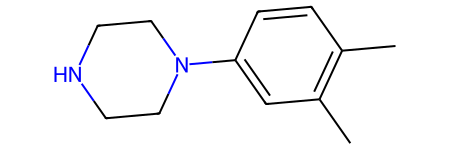

In [6]:
# Drawing molecules
mol = Chem.MolFromSmiles(data[5][1])
mol

In [7]:
# We will be using RDK fingerprint to vectorize all our SMILES structures
fingerprints = []
for i in range(len(data)):
    mol = Chem.MolFromSmiles(data[i][1])
    fingerprint_rdk = np.array(RDKFingerprint(mol))
    fingerprints.append(fingerprint_rdk)
    
fingerprints = np.array(fingerprints)
fingerprints

[10:43:42] WARNING: not removing hydrogen atom without neighbors


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [8]:
fingerprints[0].shape

(2048,)

## VISUALIZATION OF DATA
Data is obtained from the following paper - https://doi.org/10.1371/journal.pcbi.1010613 <br>
In this paper, they conducted a series of HTS to obtain the Average B-score and residual values for a series of small molecules to see their potency against Burkholderia cenocepacia.<br>
Quoting the paper,<br>

"The dataset used in the ML approach consisted of 29,537 compounds with residual growth (RG) values and average B-scores. The RG measures the ratio of bacterial growth in the presence and absence of the compounds. The B-score measures relative potency that adjusts the RG for any screening artifacts resulting from well position (row and column) in the assay plate during the HTS. The B-score is inversely proportional to compound potency, where negative B-scores indicate greater growth inhibitory activity of the compounds. To binarize the compounds, the previously established average B-score threshold of -17.5 was chosen [https://doi.org/10.1371/journal.pone.0128587]. Overall, 256 small molecules were classified as growth inhibitory."

Staying true to the essence of the paper, we will be setting a threshold of -17.5 for B-score in our data as well, i.e. below this threshold, the compound is labeled active, and otherwise inactive.

In [9]:
# Checking data for number of active compounds
# idx - ID, SMILE, B, RES, is_active
count = 0
for i in range(len(data)):
    if float(data[i][2]) <= -17.5:
        if float(data[i][4]) == 1:
            count += 1
print("Number of active compounds =",count)
# This follows what is mentioned in the paper.

Number of active compounds = 256


In [10]:
# Get the B-score values and labels
Bscores = []
active = []
is_active = []
sample_id = []

for i in range(len(data)):
    Bscores.append(float(data[i][2]))

    is_active.append(int(data[i][4]))
    sample_id.append(data[i][0])

    if float(data[i][4]) == 0:
        active.append("Inactive")
    else:
         active.append("Active")

compound_idx = np.arange(len(Bscores))
is_active = np.array(is_active)
sample_id = np.array(sample_id)

[Text(0.5, 0, 'Compound Index'), Text(0, 0.5, 'B-Score')]

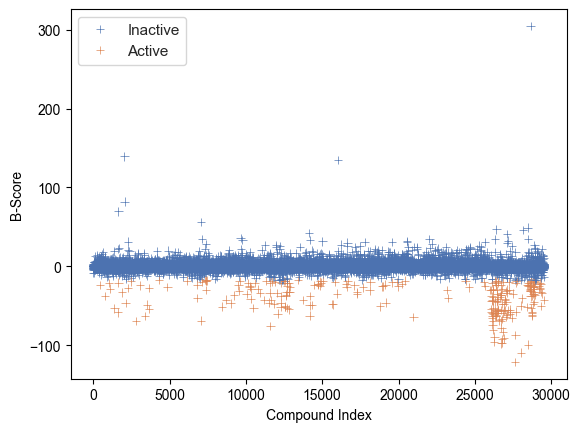

In [11]:
# Visualizing data
# Plot B-scores

fig, ax = plt.subplots()
# plt.scatter(compound_idx[0:100], Bscores[0:100], c ="blue")
sns.set(style='whitegrid')
sns.scatterplot(x=compound_idx,
                    y=Bscores,
                    hue=active, marker='+')

# ax.set_ylim(-500, 100)
ax.set(xlabel='Compound Index', ylabel='B-Score')

In [12]:
print(fingerprints.shape)
print(is_active.shape)
print(sample_id.shape)

(29537, 2048)
(29537,)
(29537,)


## Splitting Imbalanced Data 
Our data is heavily imbalanced and it is important to balance the major and minor labels. Therefore, we do random oversampling of the minor class.


In [13]:
# Testing split function: Without validation set & sample_id
test_x, test_y, test_ids, train_x, train_y, train_ids = \
    emc.test_val_train_split_w_oversampling(fingerprints, 
                                            is_active, 
                                            sample_id=sample_id,
                                            oversample_type='smote',
                                            test_ratio=0.2,
                                            train_minor_label_oversample_ratio=0.2,
                                            seed=0)

Input data's major & minor label ratio:
29281 : 256 = 99.13% : 0.87%

Test : Train
5907 :  23630

Train size before oversampling:  23630
Train size after oversampling:  23671

Resampled train data's major & minor label ratio:
23425 : 246 = 98.96% : 1.04%

Resampled data's test & train ratio:
5907 : 23671 = 19.97% : 80.03%



In [ ]:
# Create small balanced undersampled dataset for testing out emc

major_label_idx_arr = np.where(is_active==0)[0]
minor_label_idx_arr = np.where(is_active==1)[0]
np.random.shuffle(major_label_idx_arr)

# slice major label index array to the same length as minor label index array
major_label_idx_arr = major_label_idx_arr[:len(minor_label_idx_arr)]

assert len(major_label_idx_arr)== len(minor_label_idx_arr)

small_fingerprints = np.concatenate((fingerprints[major_label_idx_arr], fingerprints[minor_label_idx_arr]), axis=0)
small_is_active = np.concatenate((is_active[major_label_idx_arr], is_active[minor_label_idx_arr]), axis=0)
small_sample_id = np.concatenate((sample_id[major_label_idx_arr], sample_id[minor_label_idx_arr]), axis=0)

assert len(small_fingerprints)==len(small_is_active)

print(f"small data shape: {small_fingerprints.shape}\nsmall label shape: {small_is_active.shape}\nsmall sample_id shape: {small_sample_id.shape}")

small data shape: (512, 2048)
small label shape: (512,)
small sample_id shape: (512,)


### Model configuration

In [15]:
# Configuration for both EMC and random sampling models
config={
    "emc_dir_path":None,
    "rand_sampling_dir_path":None,

    # number of emc or random sampling simulations to run 
    "start_sim":None, # if None, range(0,n_sim); else range(start_sim, n_sim)
    "n_sim":10,
    
    # ratio [0.0,1.0] of samples to fit model before sampling
    "initial_train_ratio":0.05,
    
    # 'ros' OR 'smote' 
    "oversample_type":'smote',                  
    
    # ratio [0.0,1.0] OR number of samples
    "test_ratio":0.2,

    # ratio [0.0,1.0] OR number of samples
    "train_minor_label_oversample_ratio":0.2,
    
    "log_freq":20,
    "logger_emc":None,
    "logger_rand_sampler":None,
}

### Set up results directory and logger  

In [ ]:
# Make new directory to store results

# emc sampling results directory
emc_dir_path = emc.make_unique_file_or_dir_name("drug_emc_res")
os.mkdir(emc_dir_path)

# random sampling results directory
rand_sampling_dir_path = emc.make_unique_file_or_dir_name("drug_rand_sampling_res")
os.mkdir(rand_sampling_dir_path)

config['emc_dir_path'] = emc_dir_path
config['rand_sampling_dir_path'] = rand_sampling_dir_path

In [ ]:
# # Manually set directory paths

# emc_dir_path="drug_emc_res"
# rand_sampling_dir_path="drug_rand_sampling_res"
# config['emc_dir_path'] = emc_dir_path
# config['rand_sampling_dir_path'] = rand_sampling_dir_path

In [20]:
# Set up logger for emc sampling simulation
logger_emc = logging.getLogger("emc_logger")
logger_emc.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M')
file_handler = logging.FileHandler(f'{emc_dir_path}/emc.log')
file_handler.setFormatter(formatter)

logger_emc.addHandler(file_handler)

In [21]:
# Set up logger for random sampling simulation
logger_rand_sampler = logging.getLogger("rand_sampler_logger")
logger_rand_sampler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s %(message)s', datefmt='%Y-%m-%d %H:%M')
file_handler = logging.FileHandler(f'{rand_sampling_dir_path}/rand_sampling.log')
file_handler.setFormatter(formatter)

logger_rand_sampler.addHandler(file_handler)

In [ ]:
logger_emc.propagate = False
logger_rand_sampler.propagate = False

# Add logger objects to config
config['logger_emc']=logger_emc
config['logger_rand_sampler']=logger_rand_sampler

### Run Expected Model Change Simulation on Molecular Fingerprinting Data
Logistic regression will be our base learner

In [ ]:
# EMC simulation on small test case data
emc.run_l_simulations_emc(small_fingerprints, small_is_active, sample_id=small_sample_id, **config)

# EMC simulation on whole data
# emc.run_l_simulations_emc(fingerprints, is_active, sample_id=sample_id, **config)

In [ ]:
# Random Sampling simulation on small test case data
emc.run_n_simulations_random_sampling(small_fingerprints, small_is_active, **config)

# Random Sampling simulation on whole data
# emc.run_n_simulations_random_sampling(fingerprints, is_active, **config)

In [20]:
# Load EMC results
n_sim_accuracy_ls, n_sim_precision_ls, n_sim_recall_ls = [],[],[]

for i in range(config['n_sim']):
    n_sim_accuracy_ls.append(np.load(f"{config['emc_dir_path']}/{i}_sim_emc_accuracy.npy"))
    n_sim_precision_ls.append(np.load(f"{config['emc_dir_path']}/{i}_sim_emc_precision.npy"))
    n_sim_recall_ls.append(np.load(f"{config['emc_dir_path']}/{i}_sim_emc_recall.npy"))

In [21]:
# Load Random Sampling results
n_sim_accuracy_random_ls, n_sim_precision_random_ls, n_sim_recall_random_ls = [],[],[]

for i in range(config['n_sim']):
    n_sim_accuracy_random_ls.append(np.load(f"{config['rand_sampling_dir_path']}/{i}_sim_rand_sample_accuracy.npy"))
    n_sim_precision_random_ls.append(np.load(f"{config['rand_sampling_dir_path']}/{i}_sim_rand_sample_precision.npy"))
    n_sim_recall_random_ls.append(np.load(f"{config['rand_sampling_dir_path']}/{i}_sim_rand_sample_recall.npy"))

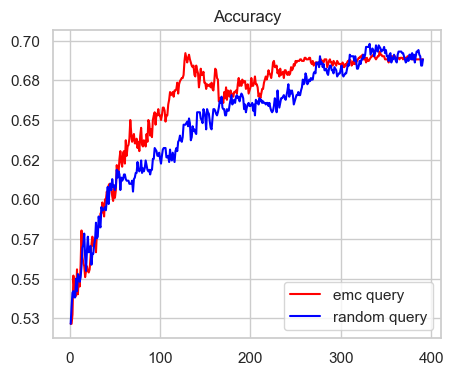

In [44]:
n_updates =  len(n_sim_accuracy_ls[0])

plt.figure(figsize=(5,4))
emc.plot_metrics(n_sim_accuracy_ls, n_updates, plot_separate_sim=False, color='red', label='emc query')
emc.plot_metrics(n_sim_accuracy_random_ls, n_updates, plot_separate_sim=False, color='blue', label='random query')
plt.title('Accuracy')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.show()

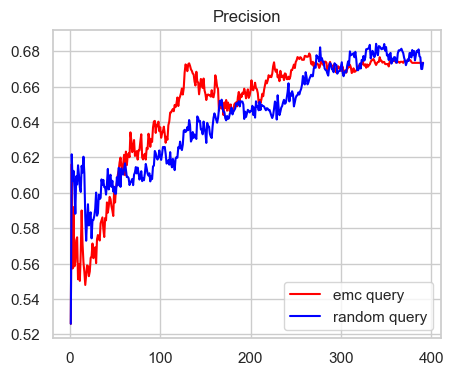

In [45]:
plt.figure(figsize=(5,4))
emc.plot_metrics(n_sim_precision_ls, n_updates, plot_separate_sim=False, color='red', label='emc query')
emc.plot_metrics(n_sim_precision_random_ls, n_updates, plot_separate_sim=False, color='blue', label='random query')
plt.title('Precision')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.show()

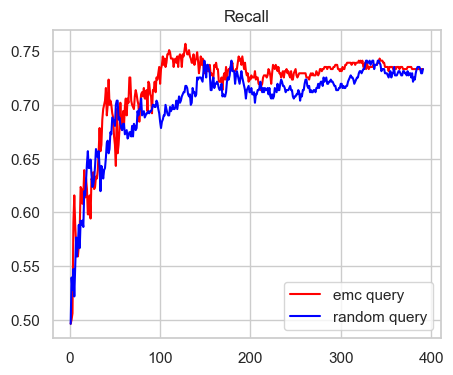

In [46]:
plt.figure(figsize=(5,4))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
emc.plot_metrics(n_sim_recall_ls, n_updates, plot_separate_sim=False, color='red', label='emc query')
emc.plot_metrics(n_sim_recall_random_ls, n_updates, plot_separate_sim=False, color='blue', label='random query')
plt.title('Recall')
plt.show()

In [ ]:
# Performance comparison to no-sampling model
# Testing split function: Without validation set & sample_id
 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

test_x, test_y, train_x, train_y = \
    emc.test_val_train_split_w_oversampling(small_fingerprints,
                                            small_is_active,
                                            sample_id=None,
                                            oversample_type='smote',
                                            test_ratio=0.2,
                                            train_minor_label_oversample_ratio=0.2)

model = LogisticRegression(max_iter=1000)
model.fit(train_x, train_y)
model_pred = model.predict(test_x)

# Classification metrics
model_accuracy = accuracy_score(test_y, model_pred)
model_precision = precision_score(test_y, model_pred)
model_recall = recall_score(test_y, model_pred)

print(f"Model accuracy: {round(model_accuracy,2)}\nModel precision: {round(model_precision,2)}\nModel recall: {round(model_recall,2)}")

Input data's major & minor label ratio:
256 : 256 = 50.0% : 50.0%

Test : Train
102 :  410

Train size before oversampling:  410
Train size after oversampling:  410

Resampled train data's major & minor label ratio:
205 : 205 = 50.0% : 50.0%

Resampled data's test & train ratio:
102 : 410 = 19.92% : 80.08%

Model accuracy: 0.66
Model precision: 0.64
Model recall: 0.73
